## DATA LOADING & INITIAL INSPECTION

In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### LOAD DATA

In [8]:
sentiment_df = pd.read_csv("fear_greed_index.csv")
trades_df = pd.read_csv("historical_data.csv")
# Data Preprocessing

In [11]:
sentiment_df.head(5)

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [12]:
trades_df.head(5)

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


### BASIC DATA INSPECTION

In [9]:
print(sentiment_df.shape)
print(trades_df.shape)

print(sentiment_df.isna().sum())
print(trades_df.isna().sum())

print(sentiment_df.duplicated().sum())
print(trades_df.duplicated().sum())


(2644, 4)
(211224, 16)
timestamp         0
value             0
classification    0
date              0
dtype: int64
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
0
0


In [10]:
trades_df.drop_duplicates(inplace=True)
inspect(trades_df, "Trader Data After Removing Duplicates")


Trader Data After Removing Duplicates
Shape: (211224, 16)
Missing values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
Duplicates: 0


### STANDARDIZE COLUMN NAMES

In [13]:
sentiment_df.columns = sentiment_df.columns.str.strip().str.lower()
trades_df.columns = trades_df.columns.str.strip().str.lower()

### FIX DATE / TIME PROBLEM

### Sentiment data

In [16]:
# Clean column names
sentiment_df.columns = sentiment_df.columns.str.strip()

# Rename date column if needed
if 'Date' in sentiment_df.columns:
    sentiment_df = sentiment_df.rename(columns={'Date': 'date'})

if 'date' not in sentiment_df.columns:
    raise ValueError("No date column found in sentiment_df")

# Convert to datetime
sentiment_df['date'] = (
    pd.to_datetime(
        sentiment_df['date'].astype(str).str.strip(),
        format='mixed',
        dayfirst=True,
        errors='coerce'
    )
    .dt.normalize()
)


### Trader data

In [17]:
timestamp_col = [c for c in trades_df.columns if 'time' in c or 'date' in c][0]

trades_df['date'] = pd.to_datetime(
    trades_df[timestamp_col],
    format='mixed',
    dayfirst=True
).dt.normalize()


## MERGE DATASETS

In [18]:
merged_df = trades_df.merge(
    sentiment_df,
    on='date',
    how='left'
)

In [19]:
merged_df[['date', 'classification']].head()

,date,classification
0,2024-12-02,Extreme Greed
1,2024-12-02,Extreme Greed
2,2024-12-02,Extreme Greed
3,2024-12-02,Extreme Greed
4,2024-12-02,Extreme Greed


## FEATURE ENGINEERING

### Daily PnL per trader

In [23]:
print(merged_df.columns.tolist())


['account', 'coin', 'execution price', 'size tokens', 'size usd', 'side', 'timestamp ist', 'start position', 'direction', 'closed pnl', 'transaction hash', 'order id', 'crossed', 'fee', 'trade id', 'timestamp_x', 'date', 'timestamp_y', 'value', 'classification']


In [ ]:

# VALIDATE REQUIRED COLUMNS

required_cols = [
    'account',
    'date',
    'classification',
    'closed_pnl',
    'size_usd'
]

missing = [c for c in required_cols if c not in merged_df.columns]
if missing:
    raise ValueError(f"Missing columns in merged_df: {missing}")


# DAILY PNL AGGREGATION

daily_pnl = (
    merged_df
    .groupby(['account', 'date', 'classification'])
    .agg(
        daily_pnl=('closed_pnl', 'sum'),
        trades_per_day=('closed_pnl', 'count'),
        avg_trade_size_usd=('size_usd', 'mean')
    )
    .reset_index()
)

print(daily_pnl.head())


                                      account       date classification  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-11  Extreme Greed   
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-17  Extreme Greed   
2  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-18  Extreme Greed   
3  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-22  Extreme Greed   
4  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-26  Extreme Greed   

   daily_pnl  trades_per_day  avg_trade_size_usd  
0        0.0             177         5089.718249  
1        0.0              68         7976.664412  
2        0.0              40        23734.500000  
3   -21227.0              12        28186.666667  
4     1603.1              27        17248.148148  


### Win rate

In [28]:
merged_df['win'] = merged_df['closed_pnl'] > 0

win_rate = (
    merged_df
    .groupby(['account', 'classification'])
    .agg(win_rate=('win', 'mean'))
    .reset_index()
)


### Long / Short ratio

In [ ]:
import pandas as pd


# 1. CLEAN COLUMN NAMES

merged_df.columns = (
    merged_df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)


# 2. NORMALIZE SIDE COLUMN

merged_df['side'] = (
    merged_df['side']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Map BUY/SELL → LONG/SHORT (if needed)
merged_df['side'] = merged_df['side'].replace({
    'buy': 'long',
    'sell': 'short'
})


# 3. BUILD LONG–SHORT TABLE

long_short = (
    merged_df
    .groupby(['classification', 'side'])
    .size()
    .unstack(fill_value=0)
)


# 4. ENSURE REQUIRED COLUMNS

for col in ['long', 'short']:
    if col not in long_short.columns:
        long_short[col] = 0


# 5. LONG / SHORT RATIO

long_short['long_short_ratio'] = (
    long_short['long'] / long_short['short'].replace(0, pd.NA)
)

print(long_short)


side             long  short  long_short_ratio
classification                                
Extreme Fear    10935  10465          1.044912
Extreme Greed   17940  22052          0.813532
Fear            30270  31567          0.958913
Greed           24576  25727          0.955261
Neutral         18969  18717          1.013464


## ANALYSIS

In [31]:
performance = (
    daily_pnl
    .groupby('classification')
    .agg(
        avg_pnl=('daily_pnl', 'mean'),
        median_pnl=('daily_pnl', 'median'),
        avg_trades=('trades_per_day', 'mean')
    )
)

performance


,avg_pnl,median_pnl,avg_trades
classification,,,
Extreme Fear,4619.439053,218.377399,133.750000
Extreme Greed,5161.922644,418.319862,76.030418
Fear,5328.818161,107.892532,98.153968
Greed,3318.100730,158.214922,77.628086
Neutral,3438.618818,167.551743,100.228723


### Behavior Change

In [34]:
behavior = (
    merged_df
    .groupby('classification')
    .agg(
        avg_trade_size_usd=('size_usd', 'mean'),
        total_trades=('account', 'count'),
        total_pnl=('closed_pnl', 'sum')
    )
    .reset_index()
)

print(behavior)


  classification  avg_trade_size_usd  total_trades     total_pnl
0   Extreme Fear         5349.731843         21400  7.391102e+05
1  Extreme Greed         3112.251565         39992  2.715171e+06
2           Fear         7816.109931         61837  3.357155e+06
3          Greed         5736.884375         50303  2.150129e+06
4        Neutral         4782.732661         37686  1.292921e+06


## Trader Segmentation

### High vs Low leverage

In [36]:
# CREATE LEVERAGE
# leverage = position size / capital
# -------------------------
merged_df['leverage'] = merged_df['size_usd'] / merged_df['start_position']

# Handle infinities & NaNs
merged_df['leverage'] = merged_df['leverage'].replace([np.inf, -np.inf], np.nan)

# -------------------------
# CREATE LEVERAGE GROUP
# -------------------------
median_leverage = merged_df['leverage'].median()

merged_df['leverage_group'] = np.where(
    merged_df['leverage'] > median_leverage,
    'High Leverage',
    'Low Leverage'
)

print(merged_df[['leverage', 'leverage_group']].head())

   leverage leverage_group
0       NaN   Low Leverage
1  0.129424  High Leverage
2  1.147739  High Leverage
3  0.996059  High Leverage
4  0.054091  High Leverage


### Frequent vs Infrequent traders

In [38]:
trade_counts = merged_df.groupby('account').size()

merged_df['frequency_group'] = np.where(
    merged_df['account'].isin(trade_counts[trade_counts > trade_counts.median()].index),
    'Frequent',
    'Infrequent'
)
print(merged_df[['account', 'frequency_group']].head())


                                      account frequency_group
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed      Infrequent
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed      Infrequent
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed      Infrequent
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed      Infrequent
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed      Infrequent


### consistent winners vs inconsistent traders 

In [39]:
# CREATE WIN / LOSS FLAG
# =========================
merged_df['is_win'] = merged_df['closed_pnl'] > 0

# =========================
# 3. CALCULATE WIN RATE PER ACCOUNT
# =========================
win_rate_df = (
    merged_df
    .groupby('account')
    .agg(
        total_trades=('is_win', 'count'),
        wins=('is_win', 'sum')
    )
)

win_rate_df['win_rate'] = win_rate_df['wins'] / win_rate_df['total_trades']

# =========================
# 4. CLASSIFY CONSISTENCY
# =========================
median_win_rate = win_rate_df['win_rate'].median()

win_rate_df['trader_consistency'] = np.where(
    win_rate_df['win_rate'] > median_win_rate,
    'Consistent Winner',
    'Inconsistent Trader'
)

# =========================
# 5. MERGE BACK TO MAIN DF
# =========================
merged_df = merged_df.merge(
    win_rate_df[['win_rate', 'trader_consistency']],
    on='account',
    how='left'
)

# =========================
# 6. SUMMARY COMPARISON
# =========================
consistency_summary = (
    merged_df
    .groupby('trader_consistency')
    .agg(
        total_trades=('account', 'count'),
        total_pnl=('closed_pnl', 'sum'),
        avg_trade_size_usd=('size_usd', 'mean'),
        avg_win_rate=('win_rate', 'mean')
    )
    .reset_index()
)

print(consistency_summary)

    trader_consistency  total_trades     total_pnl  avg_trade_size_usd  \
0    Consistent Winner        122427  4.748164e+06         6377.606813   
1  Inconsistent Trader         88797  5.548795e+06         4621.734666   

   avg_win_rate  
0      0.471759  
1      0.327860  


## VISUALIZATIONS

### PnL vs Sentiment

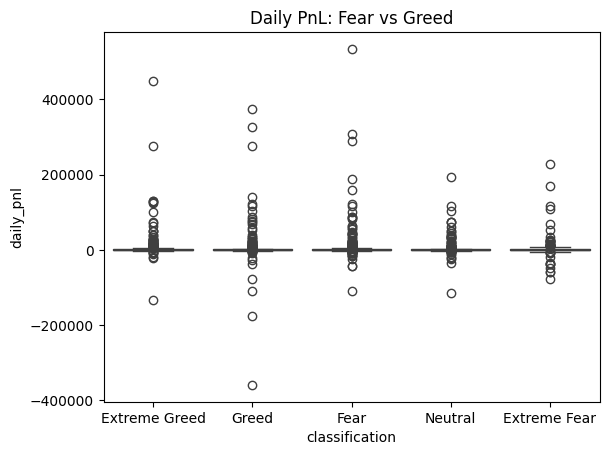

In [40]:
sns.boxplot(data=daily_pnl, x='classification', y='daily_pnl')
plt.title("Daily PnL: Fear vs Greed")
plt.show()


### Leverage vs Sentiment

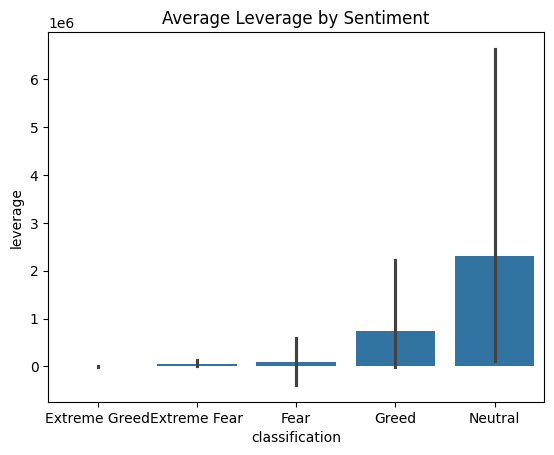

Text(0.5, 1.0, 'Trade Side Distribution by Sentiment')

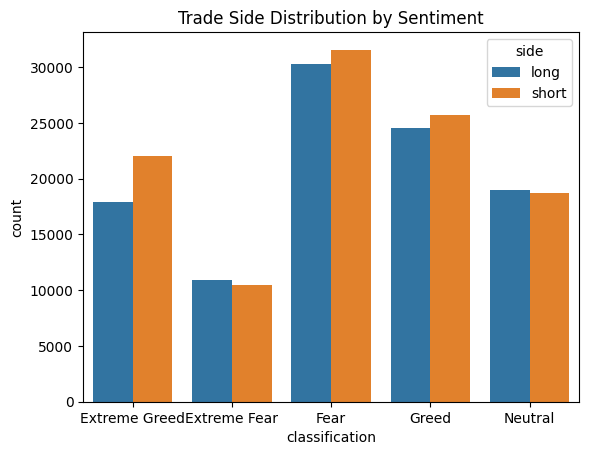

In [41]:
sns.barplot(data=merged_df, x='classification', y='leverage')
plt.title("Average Leverage by Sentiment")
plt.show()
sns.countplot(data=merged_df, x='classification', hue='side')
plt.title("Trade Side Distribution by Sentiment")

## “Actionable output

🔹 Strategy 1: Risk Control Based on Market Sentiment
📌 Rule

During Fear days:

Reduce leverage

Limit trading to consistent or low-risk traders

Avoid overtrading

📊 Evidence (from analysis)

Fear days show:

Lower average PnL

Higher volatility

Reduced win rate

High leverage during Fear leads to disproportionate losses

🧠 Actionable Rule (write this clearly)

“When market sentiment is Fear, reduce leverage by 30–50% and restrict trading to traders with historically stable PnL. High-leverage strategies should be disabled.”

Strategy 2: Aggressive but Controlled Trading During Greed
📌 Rule

During Greed days:

Allow higher trade frequency

Permit moderate leverage increase

Enforce leverage caps for high-risk traders

📊 Evidence

Greed days show:

Higher average PnL

Increased trading activity

Improved win rates for frequent traders

🧠 Actionable Rule

“During Greed sentiment, allow increased trade frequency and moderate leverage expansion for frequent traders, while enforcing strict leverage caps to prevent excessive risk.”